 # ADDA for ST

In [1]:
import warnings
from math import ceil
import glob
import os
import datetime
from itertools import chain
from copy import deepcopy

from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import mean_squared_error

import torch
from torch.nn import functional as F
from torch import nn

# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")


/tmp/ipykernel_699391/2594000529.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_MARKERS = 20
N_MIX = 8
N_SPOTS = 20000
TRAIN_USING_ALL_ST_SAMPLES = False

SAMPLE_ID_N = "151673"

BATCH_SIZE = 512
NUM_WORKERS = 4
INITIAL_TRAIN_EPOCHS = 100

EARLY_STOP_CRIT = 100
MIN_EPOCHS = INITIAL_TRAIN_EPOCHS


EARLY_STOP_CRIT_ADV = 10
MIN_EPOCHS_ADV = 10


In [3]:
results_folder = os.path.join("results", script_start_time)
model_folder = os.path.join("model_cell_dart", script_start_time)

model_folder = os.path.join("model_cell_dart", "TESTING")

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

if not os.path.isdir(results_folder):
    os.makedirs(results_folder)


 # Define model components

In [4]:
class MLPEncoder(nn.Module):
    def __init__(self, inp_dim, emb_dim):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(inp_dim, 1024),
            nn.BatchNorm1d(1024, eps=0.001, momentum=0.99),
            nn.ELU(),
            nn.Linear(1024, emb_dim),
            nn.BatchNorm1d(emb_dim, eps=0.001, momentum=0.99),
            nn.ELU(),
        )

    def forward(self, x):
        return self.encoder(x)



In [5]:
class Classifier(nn.Module):
    def __init__(self, emb_dim, ncls_source):
        super().__init__()

        self.head = nn.Sequential(nn.Linear(emb_dim, ncls_source), nn.LogSoftmax(dim=1))

    def forward(self, x):
        return self.head(x)



In [6]:
class Discriminator(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(emb_dim, 32),
            nn.BatchNorm1d(32, eps=0.001, momentum=0.99),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        return self.head(x)



In [7]:
def set_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad



In [8]:
class ADDAST(nn.Module):
    def __init__(self, inp_dim, emb_dim, ncls_source):
        super().__init__()

        self.source_encoder = MLPEncoder(inp_dim, emb_dim)
        self.target_encoder = MLPEncoder(inp_dim, emb_dim)
        self.clf = Classifier(emb_dim, ncls_source)
        self.dis = Discriminator(emb_dim)

        self.is_encoder_source = True

    def forward(self, x):
        if self.is_encoder_source:
            x = self.source_encoder(x)
        else:
            x = self.target_encoder(x)

        x = self.clf(x)

        return x

    def pretraining(self):
        self.is_encoder_source = True
        set_requires_grad(self.source_encoder, True)
        set_requires_grad(self.clf, True)

    def advtraining(self, train_dis=True):
        set_requires_grad(self.source_encoder, False)

        if train_dis:
            self.train_discriminator()
        else:
            self.train_target_encoder()

    def target_inference(self):
        self.is_encoder_source = False

    def train_discriminator(self):
        set_requires_grad(self.target_encoder, False)
        set_requires_grad(self.dis, True)

    def train_target_encoder(self):
        set_requires_grad(self.target_encoder, True)
        set_requires_grad(self.dis, False)

    def set_encoder(self, encoder="source"):
        if encoder == "source":
            self.is_encoder_source = True
        elif encoder == "target":
            self.is_encoder_source = False
        else:
            current_encoder_str = "'source'" if self.is_encoder_source else "'target'"
            warnings.warn(
                f"encoder parameter should be 'source' or 'target', got {encoder}; encoder is currently {current_encoder_str}",
                RuntimeWarning,
            )



In [9]:
class SpotDataset(torch.utils.data.Dataset):
    """Dataset for cell spots. Returns a spot with GEx data, and optionally cell type distribution"""

    def __init__(self, X, Y=None):
        """
        Args:
            X (array_like of rank 2): An (n_spots, n_genes) array of normalized log gene expression values.
            Y (array_like of rank 2, optional): An (n_spots, n_cell_types) array of cell type distribution.
        """
        super().__init__()

        self.X = torch.as_tensor(X).float()
        assert self.X.dim() == 2, f"X should be rank 2, got {self.X.dim()}"

        if Y is None:
            self.Y = Y
        else:
            self.Y = torch.as_tensor(Y).float()
            assert self.Y.dim() == 2, f"Y should be rank 2, got {self.Y.dim()}"
            assert len(self.X) == len(self.Y), "X and Y unequal lengths"

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.Y is None:
            return self.X[idx]
        else:
            return self.X[idx], self.Y[idx]



 # Prepare Data
 ## Data load
 ### Load SpatialLIBD Data

In [10]:
SPATIALLIBD_DIR = "./data/spatialLIBD"

sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

adata_dir = os.path.join(SPATIALLIBD_DIR, "adata")

adata_spatialLIBD_d = {}

for name in glob.glob(os.path.join(adata_dir, "adata_spatialLIBD-*.h5ad")):
    sample_id = name.partition("-")[2].rpartition(".")[0]
    # print(sample_id)
    adata_spatialLIBD_d[sample_id] = sc.read_h5ad(name)


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
h5py                        3.6.0
igraph                      0.9.10
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
joblib                      1.1.0
jupyter_server              1.18.1
kiwisolver                  1.4.2
leidenalg                   0.8.10
llvmlite                    0.38.0
matplotlib                  3.5.1
matplo

 ### Load Single Cell Data

In [11]:
adata_sc_dlpfc = sc.read_h5ad("./data/sc_dlpfc/adata_sc_dlpfc.h5ad")
sc.pp.normalize_total(adata_sc_dlpfc, inplace=True, target_sum=1e6)
adata_sc_dlpfc.var_names_make_unique()


normalizing counts per cell
    finished (0:00:00)


 ## Find Marker Genes

In [12]:
# Preprocessing
# adata_sc_dlpfc.var['mt'] = adata_sc_dlpfc.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata_sc_dlpfc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# sc.pp.normalize_total(adata_sc_dlpfc)

# #PCA and clustering : Known markers with 'cell_subclass'
# sc.tl.pca(adata_sc_dlpfc, svd_solver='arpack')
# sc.pp.neighbors(adata_sc_dlpfc, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_sc_dlpfc)
# sc.tl.leiden(adata_sc_dlpfc, resolution = 0.5)
# sc.pl.umap(adata_sc_dlpfc, color=['leiden','cell_subclass'])


In [13]:
# sc.tl.rank_genes_groups(adata_sc_dlpfc, 'cell_subclass', method='wilcoxon')
# # sc.pl.rank_genes_groups(adata_sc_dlpfc, n_genes=20, sharey=False)
# genelists = adata_sc_dlpfc.uns['rank_genes_groups']['names']
# df_genelists = pd.DataFrame.from_records(genelists)
# df_genelists.to_pickle('data/sc_dlpfc/df_genelists.pkl')


In [14]:
df_genelists = pd.read_pickle("data/sc_dlpfc/df_genelists.pkl")
res_genes = []
for column in df_genelists.head(NUM_MARKERS):
    res_genes.extend(df_genelists.head(NUM_MARKERS)[column].tolist())
res_genes_ = list(set(res_genes))


 ### Select same gene features

In [15]:
adata_spatialLIBD = ad.concat(
    adata_spatialLIBD_d.values(), label="sample_id", keys=adata_spatialLIBD_d.keys()
)
adata_spatialLIBD.obs_names_make_unique()
sc.pp.normalize_total(adata_spatialLIBD, inplace=True, target_sum=1e6)
st_sample_id_l = adata_spatialLIBD.obs["sample_id"].unique()


normalizing counts per cell


/projects/wma/.conda2/envs/agreda2/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)


In [16]:
adata_spatialLIBD.var_names_make_unique()
inter_genes = [val for val in res_genes_ if val in adata_spatialLIBD.var.index]
print("Selected Feature Gene number", len(inter_genes))
adata_sc_dlpfc = adata_sc_dlpfc[:, inter_genes]

adata_spatialLIBD = adata_spatialLIBD[:, inter_genes]



Selected Feature Gene number 362


 ## Format Data

### Array of single cell & spatial data
- Single cell data with labels
- Spatial data without labels


 ### Generate Pseudospots

In [17]:
def random_mix(Xs, ys, nmix=5, n_samples=10000, seed=0):
    """Creates a weighted average random sampling of gene expression, and the
    corresponding weights.

    Args:
        X (:obj:, array_like of `float`): Matrix containing single cell samples
            and their GEx profiles
        y (:obj:, array_like of `int`): Array of cell type labels

    Shape:
        - X: `(N, C)`, where `N` is the number of single cell samples, and `C`
        is the number of genes
        - y: `(N,)`, where `N` is the number of single cell samples
        - pseudo_gex: :math: `(N_{out}, C)` where
        :math: `N_{out} = \text{n\_samples}` and `C` is the number of genes
        - ctps: `(N_{out}, C_{types})`
        where :math: `N_{out} = \text{n\_samples}` and :math: `C_{types}`
        is the number of cell types.

    Returns:
         - pseudo_gex (ndarray): Matrix containing pseudo-spot samples and their
         cell type proportion weighted averages
         - ctps (ndarray): Matrix containing pseudo-spot samples and their cell
         type proportions
    """
    # Define empty lists
    pseudogexs, ys_new = [], []
    ys_ = OneHotEncoder().fit_transform(ys.reshape(-1, 1)).toarray()

    rstate = np.random.RandomState(seed)
    fraction_all = rstate.rand(n_samples, nmix)
    randindex_all = rstate.randint(len(Xs), size=(n_samples, nmix))

    for i in range(n_samples):
        # fraction: random fraction across the "nmix" number of sampled cells
        fraction = fraction_all[i]
        fraction = fraction / np.sum(fraction)
        fraction = np.reshape(fraction, (nmix, 1))

        # Random selection of the single cell data by the index
        randindex = randindex_all[i]
        ymix = ys_[randindex]
        # Calculate the fraction of cell types in the cell mixture
        yy = np.sum(ymix * fraction, axis=0)
        # Calculate weighted gene expression of the cell mixture
        XX = np.asarray(Xs[randindex]) * fraction
        XX_ = np.sum(XX, axis=0)

        # Add cell type fraction & composite gene expression in the list
        ys_new.append(yy)
        pseudogexs.append(XX_)

    pseudogexs = np.asarray(pseudogexs)
    ys_new = np.asarray(ys_new)

    return pseudogexs, ys_new

In [18]:
def log_minmaxscale(arr):
    """returns log1pc and min/max normalized arr"""
    arrd = len(arr)
    arr = np.log1p(arr)
    return (arr - np.reshape(np.min(arr, axis=1), (arrd, 1))) / np.reshape(
        (np.max(arr, axis=1) - np.min(arr, axis=1)), (arrd, 1)
    )



In [19]:
df_sc = adata_sc_dlpfc.to_df()
df_sc.index = pd.MultiIndex.from_frame(adata_sc_dlpfc.obs.reset_index())

sc_sub_dict = dict(zip(range(df_genelists.shape[1]), df_genelists.columns.tolist()))
sc_sub_dict2 = dict((y, x) for x, y in sc_sub_dict.items())



In [20]:
lab_sc_sub = df_sc.index.get_level_values("cell_subclass")
lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
lab_sc_num = np.asarray(lab_sc_num, dtype="int")

mat_sc_train, mat_sc_test, lab_sc_num_train, lab_sc_num_test = train_test_split(
    df_sc.to_numpy(),
    lab_sc_num,
    test_size=0.2,
    random_state=225,
    stratify=lab_sc_num,
)

sc_mix_train, lab_mix_train = random_mix(
    mat_sc_train, lab_sc_num_train, nmix=N_MIX, n_samples=N_SPOTS
)
sc_mix_test, lab_mix_test = random_mix(
    mat_sc_test, lab_sc_num_test, nmix=N_MIX, n_samples=N_SPOTS // 4
)


sc_mix_train_s = log_minmaxscale(sc_mix_train)
sc_mix_test_s = log_minmaxscale(sc_mix_test)





 ### Format Spatial Data

In [21]:
mat_sp_test_d = {}
mat_sp_test_s_d = {}
for sample_id in st_sample_id_l:
    mat_sp_test_d[sample_id] = adata_spatialLIBD[
        adata_spatialLIBD.obs.sample_id == sample_id
    ].X.todense()

    mat_sp_test_s_d[sample_id] = log_minmaxscale(mat_sp_test_d[sample_id])

if TRAIN_USING_ALL_ST_SAMPLES:
    mat_sp_train = adata_spatialLIBD.X.todense()
    mat_sp_train_s = log_minmaxscale(mat_sp_train)
else:
    mat_sp_train_d = mat_sp_test_d
    mat_sp_train_s_d = mat_sp_test_s_d


 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [22]:
source_train_set = SpotDataset(deepcopy(sc_mix_train_s), deepcopy(lab_mix_train))
source_test_set = SpotDataset(deepcopy(sc_mix_test_s), deepcopy(lab_mix_test))

# if TRAIN_USING_ALL_ST_SAMPLES:
#     target_train_set = SpotDataset(mat_sp_train_s)

# target_test_set_d = {}
# for sample_id in st_sample_id_l:
#     target_test_set_d[sample_id] = SpotDataset(mat_sp_test_s_d[sample_id])

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
)
# dataloader_source_test = torch.utils.data.DataLoader(
#     source_test_set,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=NUM_WORKERS,
#     pin_memory=False,
# )

# dataloader_target_test_d = {}
# for sample_id in st_sample_id_l:
#     dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
#         target_test_set_d[sample_id],
#         batch_size=BATCH_SIZE,
#         shuffle=True,
#         num_workers=NUM_WORKERS,
#         pin_memory=False,
#     )

# if TRAIN_USING_ALL_ST_SAMPLES:
#     dataloader_target_train = torch.utils.data.DataLoader(
#         target_train_set,
#         batch_size=BATCH_SIZE,
#         shuffle=True,
#         num_workers=NUM_WORKERS,
#         pin_memory=False,
#     )
# else:
#     dataloader_target_train_d = dataloader_target_test_d


 ## Define Model

In [23]:
model = ADDAST(sc_mix_train_s.shape[1], emb_dim=64, ncls_source=lab_mix_train.shape[1])

model.to(device)


ADDAST(
  (source_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (target_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (clf): Classifier(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
      (1): Lo

 ## Pretrain

In [24]:
pretrain_folder = os.path.join(model_folder, "pretrain")

if not os.path.isdir(pretrain_folder):
    os.makedirs(pretrain_folder)


In [25]:
pre_optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-07
)

criterion = nn.KLDivLoss(reduction="batchmean")


In [26]:
def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, (x, y_true) in enumerate(dataloader):

            x = x.to(torch.float32).to(device)
            y_true = y_true.to(torch.float32).to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y_true)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(x))

    # print(len(loss_running), len(mean_weights))
    return np.average(loss_running, weights=mean_weights)



In [27]:
model.pretraining()

In [28]:
# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0

# Train
print("Start pretrain...")
outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
inner = tqdm(total=len(dataloader_source_train), desc=f"Batch", position=1)
for epoch in range(INITIAL_TRAIN_EPOCHS):

    # check to see if validation loss has plateau'd
    if early_stop_count >= EARLY_STOP_CRIT and epoch > MIN_EPOCHS:
        print(
            f"Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch"
        )
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "optimizer": pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(
            checkpoint, os.path.join(pretrain_folder, f"checkpt_earlystop_{epoch}.pth")
        )
        break

    early_stop_count += 1

    # Train mode
    model.train()
    loss_running = []
    mean_weights = []

    inner.refresh()  # force print final state
    inner.reset()  # reuse bar
    for _, (x, y_true) in enumerate(dataloader_source_train):
        # lr_history_running.append(scheduler.get_last_lr())

        pre_optimizer.zero_grad()
        x = x.to(torch.float32).to(device)
        y_true = y_true.to(torch.float32).to(device)

        y_pred = model(x)

        loss = criterion(y_pred, y_true)

        loss_running.append(loss.item())

        # we will weight average by batch size later
        mean_weights.append(len(x))

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        loss.backward()
        pre_optimizer.step()
        # Change the learning rate
        # scheduler.step()

        inner.update(1)

    loss_history.append(np.average(loss_running, weights=mean_weights))

    loss_history_running.append(loss_running)

    # Evaluate mode
    model.eval()
    with torch.no_grad():
        curr_loss_val = compute_acc(dataloader_source_train, model)
        loss_history_val.append(curr_loss_val)

    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "optimizer": pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f"best_model.pth"))
        early_stop_count = 0

    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "optimizer": pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f"checkpt{epoch}.pth"))

    # Print the results
    outer.update(1)
    print(
        "epoch:",
        epoch,
        "train loss:",
        round(loss_history[-1], 6),
        "validation loss:",
        round(loss_history_val[-1], 6),  # "next_lr:", scheduler.get_last_lr(),
    )

# Save final model
checkpoint = {
    "epoch": epoch,
    "model": model,
    "optimizer": pre_optimizer,
    # 'scheduler': scheduler,
    # 'scaler': scaler
}
torch.save(checkpoint, os.path.join(pretrain_folder, f"final_model.pth"))


Start pretrain...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch: 0 train loss: 1.27549 validation loss: 1.014873
epoch: 1 train loss: 0.902241 validation loss: 0.807735
epoch: 2 train loss: 0.718962 validation loss: 0.644423
epoch: 3 train loss: 0.625135 validation loss: 0.696274
epoch: 4 train loss: 0.585267 validation loss: 0.600192
epoch: 5 train loss: 0.5602 validation loss: 0.570504
epoch: 6 train loss: 0.541647 validation loss: 0.546044
epoch: 7 train loss: 0.525275 validation loss: 0.592641
epoch: 8 train loss: 0.511314 validation loss: 0.758629
epoch: 9 train loss: 0.498772 validation loss: 0.537611
epoch: 10 train loss: 0.485599 validation loss: 0.557931
epoch: 11 train loss: 0.474377 validation loss: 0.567215
epoch: 12 train loss: 0.465809 validation loss: 0.523526
epoch: 13 train loss: 0.44993 validation loss: 0.52351
epoch: 14 train loss: 0.439064 validation loss: 0.500337
epoch: 15 train loss: 0.427021 validation loss: 0.570088
epoch: 16 train loss: 0.415658 validation loss: 0.446678
epoch: 17 train loss: 0.405021 validation loss

 ## Adversarial Adaptation

In [29]:
N_ITER = 3000
EPOCHS = 1000
ALPHA_LR = 5
ALPHA = 0.6

In [30]:
advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)

In [31]:
def cycle_iter(iter):
    while True:
        yield from iter


In [32]:
def batch_generator(data, batch_size):
    """Generate batches of data.
    Given a list of numpy data, it iterates over the list and returns batches of
    the same size
    This
    """
    all_examples_indices = len(data[0])
    while True:
        mini_batch_indices = np.random.choice(
            all_examples_indices, size=batch_size, replace=False
        )
        tbr = [k[mini_batch_indices] for k in data]
        yield tbr



In [33]:


# source_train_set_eval = SpotDataset(deepcopy(sc_mix_train_s), deepcopy(lab_mix_train))
# dataloader_source_train_eval = torch.utils.data.DataLoader(
#     source_train_set_eval,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=0,
#     pin_memory=False,
# )


In [34]:
criterion_dis = nn.CrossEntropyLoss()

criterion_clf = nn.KLDivLoss(reduction="batchmean")

In [35]:
def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, (x, y_true) in enumerate(dataloader):

            x = x.to(torch.float32).to(device)
            y_true = y_true.to(torch.float32).to(device)

            y_pred = model(x)

            loss = criterion_clf(y_pred, y_true)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(x))

    # print(len(loss_running), len(mean_weights))
    return np.average(loss_running, weights=mean_weights)


def compute_acc_dis(dataloader_source, dataloader_target, model):
    len_target = len(dataloader_target)
    len_source = len(dataloader_source)

    loss_running = []
    accu_running = []
    mean_weights = []
    model.eval()
    model.source_encoder.eval()
    model.dis.eval()
    with torch.no_grad():
        targ_iter = iter(dataloader_target)
        sour_iter = iter(dataloader_source)
        for i in range(max([len_target, len_source])):
            if i >= len_target:
                x, _ = next(sour_iter)
                y_dis = torch.zeros(x.shape[0], device=device, dtype=torch.long)
            elif i >= len_source:
                x = next(targ_iter)
                y_dis = torch.ones(x.shape[0], device=device, dtype=torch.long)
            else:
                x_source, _ = next(sour_iter)
                x_target = next(targ_iter)

                y_dis = torch.cat(
                    [
                        torch.zeros(x_source.shape[0], device=device, dtype=torch.long),
                        torch.ones(x_target.shape[0], device=device, dtype=torch.long),
                    ]
                )

                x = torch.cat((x_source, x_target))

            x = x.to(torch.float32).to(device)

            emb = model.source_encoder(x)
            y_pred = model.dis(emb)

            loss = criterion_dis(y_pred, y_dis)
            accu_running.append(
                torch.mean(
                    (torch.flatten(torch.argmax(y_pred, dim=1)) == y_dis).to(
                        torch.float32
                    )
                ).cpu()
            )

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(x))
    del targ_iter
    del sour_iter
    # print(len(loss_running), len(mean_weights))
    return np.average(loss_running, weights=mean_weights), np.average(
        accu_running, weights=mean_weights
    )



In [36]:
def train_adversarial(
    model,
    save_folder,
    sc_mix_train_s,
    lab_mix_train,
    mat_sp_train_s,
    dataloader_source_train_eval,
    dataloader_target_train_eval,
):

    model.to(device)

    S_batches = batch_generator(
        [sc_mix_train_s.copy(), lab_mix_train.copy()], BATCH_SIZE
    )
    T_batches = batch_generator(
        [mat_sp_train_s.copy(), np.zeros(shape=(len(mat_sp_train_s), 2))], BATCH_SIZE
    )

    enc_optimizer = torch.optim.Adam(
        chain(
            model.source_encoder.parameters(),
            model.dis.parameters(),
            model.clf.parameters(),
        ),
        lr=0.001,
        betas=(0.9, 0.999),
        eps=1e-07,
    )

    dis_optimizer = torch.optim.Adam(
        chain(model.source_encoder.parameters(), model.dis.parameters()),
        lr=ALPHA_LR * 0.001,
        betas=(0.9, 0.999),
        eps=1e-07,
    )

    # Initialize lists to store loss and accuracy values
    loss_history_running = []

    # batch_cycler_s = cycle_iter(dataloader_source_train)
    # batch_cycler_t = cycle_iter(dataloader_target_train)

    # Train
    print("Start adversarial training...")
    outer = tqdm(total=N_ITER, desc="Iterations", position=0)

    model.advtraining()

    # Train mode
    model.set_encoder("source")

    # loss_running = []
    # accu_running = []
    # mean_weights = []

    # accu_history

    for iters in range(N_ITER):
        model.train()
        model.dis.train()
        model.clf.train()
        model.source_encoder.train()

        # x_source, y_true = next(batch_cycler_s)
        # x_target = next(batch_cycler_t)

        x_source, y_true = next(S_batches)
        x_target, _ = next(T_batches)

        set_requires_grad(model.source_encoder, True)
        set_requires_grad(model.clf, True)
        set_requires_grad(model.dis, True)

        dis_weights = deepcopy(model.dis.state_dict())
        new_dis_weights = {}
        for k in dis_weights:
            if "num_batches_tracked" not in k:
                new_dis_weights[k] = dis_weights[k]

        dis_weights = new_dis_weights

        x_source, x_target, y_true, = (
            torch.Tensor(x_source),
            torch.Tensor(x_target),
            torch.Tensor(y_true),
        )
        x_source, x_target, y_true, = (
            x_source.to(device),
            x_target.to(device),
            y_true.to(device),
        )

        x = torch.cat((x_source, x_target))

        x_d = x.detach()

        y_dis = torch.cat(
            [
                torch.ones(x_source.shape[0], device=device, dtype=torch.long),
                torch.zeros(x_target.shape[0], device=device, dtype=torch.long),
            ]
        )

        emb = model.source_encoder(x).view(x.shape[0], -1)

        y_dis_pred = model.dis(emb)
        y_clf_pred = model.clf(emb)

        loss_dis = criterion_dis(y_dis_pred, y_dis)
        loss_clf = criterion_clf(
            y_clf_pred, torch.cat((y_true, y_clf_pred[-x_target.shape[0] :].detach()))
        )

        # loss = (x_source.shape[0] / x.shape[0]) * loss_clf + alpha * loss_dis

        loss = loss_clf + ALPHA * loss_dis

        enc_optimizer.zero_grad()
        loss.backward()
        enc_optimizer.step()

        model.dis.load_state_dict(dis_weights, strict=False)

        set_requires_grad(model.source_encoder, True)
        set_requires_grad(model.clf, True)
        set_requires_grad(model.dis, True)

        source_encoder_weights = deepcopy(model.source_encoder.state_dict())
        clf_weights = deepcopy(model.clf.state_dict())

        new_clf_weights = {}
        for k in clf_weights:
            if "num_batches_tracked" not in k:
                new_clf_weights[k] = clf_weights[k]

        clf_weights = new_clf_weights

        new_source_encoder_weights = {}
        for k in source_encoder_weights:
            if "num_batches_tracked" not in k:
                new_source_encoder_weights[k] = source_encoder_weights[k]

        source_encoder_weights = new_source_encoder_weights

        # flip label
        y_dis = 1 - y_dis

        emb = model.source_encoder(x_d).view(x_d.shape[0], -1)
        y_pred = model.dis(emb)
        loss = criterion_dis(y_pred, y_dis)

        dis_optimizer.zero_grad()
        loss.backward()
        dis_optimizer.step()

        model.clf.load_state_dict(clf_weights, strict=False)
        model.source_encoder.load_state_dict(source_encoder_weights, strict=False)

        # Save checkpoint every 100
        if iters % 100 == 99 or iters >= N_ITER - 1:
            checkpoint = {
                "epoch": iters,
                "model": model,
                "dis_optimizer": dis_optimizer,
                "enc_optimizer": enc_optimizer,
                # 'scheduler': scheduler,
                # 'scaler': scaler
            }
            torch.save(checkpoint, os.path.join(save_folder, f"checkpt{iters}.pth"))

            model.eval()
            source_loss = compute_acc(dataloader_source_train_eval, model)
            _, dis_accu = compute_acc_dis(
                dataloader_source_train_eval, dataloader_target_train_eval, model
            )

            # accu_running[-100:] = [x.cpu() for x in accu_running[-100:]]

            # Print the results
            print(
                "iter:",
                iters,
                "source loss:",
                round(
                    source_loss, 6
                ),  # "dis loss:", round(np.average(loss_running[-100:], weights=mean_weights[-100:]), 6), \
                "dis accu:",
                round(dis_accu, 6),  # "next_lr:", scheduler.get_last_lr(),
            )

        outer.update(1)

    # Save final model

    checkpoint = {
        "epoch": N_ITER,
        "model": model,
        "dis_optimizer": dis_optimizer,
        "enc_optimizer": enc_optimizer,
        # 'scheduler': scheduler,
        # 'scaler': scaler
    }

    torch.save(checkpoint, os.path.join(save_folder, f"final_model.pth"))


In [37]:
if TRAIN_USING_ALL_ST_SAMPLES:
    target_train_set_eval = SpotDataset(deepcopy(mat_sp_train_s))
    dataloader_target_train_eval = torch.utils.data.DataLoader(
        target_train_set_eval,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )

    save_folder = advtrain_folder

    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))
    model = best_checkpoint["model"]

    train_adversarial(
        model,
        save_folder,
        sc_mix_train_s,
        lab_mix_train,
        mat_sp_train_s,
        dataloader_source_train,
        dataloader_target_train_eval,
    )

else:
    for sample_id in st_sample_id_l:

        save_folder = os.path.join(advtrain_folder, sample_id)
        if not os.path.isdir(save_folder):
            os.makedirs(save_folder)
        target_train_set_eval = SpotDataset(deepcopy(mat_sp_train_s_d[sample_id]))
        dataloader_target_train_eval = torch.utils.data.DataLoader(
            target_train_set_eval,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=0,
            pin_memory=False,
        )

        best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))
        model = best_checkpoint["model"]

        train_adversarial(
            model,
            save_folder,
            sc_mix_train_s,
            lab_mix_train,
            mat_sp_train_s_d[sample_id],
            dataloader_source_train,
            dataloader_target_train_eval,
        )


Start adversarial training...


Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.509984 dis accu: 0.942474
iter: 199 source loss: 1.189642 dis accu: 0.953972
iter: 299 source loss: 1.389964 dis accu: 0.870104
iter: 399 source loss: 1.186616 dis accu: 0.858728
iter: 499 source loss: 1.153805 dis accu: 0.993384
iter: 599 source loss: 1.157969 dis accu: 0.862641
iter: 699 source loss: 1.128102 dis accu: 0.830933
iter: 799 source loss: 1.057982 dis accu: 0.996127
iter: 899 source loss: 1.015269 dis accu: 0.986204
iter: 999 source loss: 0.981648 dis accu: 0.590585
iter: 1099 source loss: 0.924507 dis accu: 0.79616
iter: 1199 source loss: 0.843604 dis accu: 0.920408
iter: 1299 source loss: 0.916284 dis accu: 0.709831
iter: 1399 source loss: 0.796253 dis accu: 0.807495
iter: 1499 source loss: 0.762801 dis accu: 0.646254
iter: 1599 source loss: 0.770415 dis accu: 0.891524
iter: 1699 source loss: 0.759331 dis accu: 0.351487
iter: 1799 source loss: 0.769209 dis accu: 0.905321
iter: 1899 source loss: 0.779592 dis accu: 0.543346
iter: 1999 source loss: 

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.309397 dis accu: 0.985589
iter: 199 source loss: 1.239286 dis accu: 0.999066
iter: 299 source loss: 1.208146 dis accu: 0.996671
iter: 399 source loss: 1.245168 dis accu: 0.851628
iter: 499 source loss: 1.259018 dis accu: 0.923967
iter: 599 source loss: 1.097477 dis accu: 0.695786
iter: 699 source loss: 1.019158 dis accu: 0.841357
iter: 799 source loss: 1.037194 dis accu: 0.890314
iter: 899 source loss: 0.925019 dis accu: 0.74454
iter: 999 source loss: 0.894818 dis accu: 0.672891
iter: 1099 source loss: 0.797131 dis accu: 0.929853
iter: 1199 source loss: 0.751595 dis accu: 0.95149
iter: 1299 source loss: 0.734466 dis accu: 0.394374
iter: 1399 source loss: 0.728682 dis accu: 0.265203
iter: 1499 source loss: 0.683785 dis accu: 0.769343
iter: 1599 source loss: 0.671113 dis accu: 0.841845
iter: 1699 source loss: 0.63524 dis accu: 0.671876
iter: 1799 source loss: 0.613936 dis accu: 0.85727
iter: 1899 source loss: 0.62527 dis accu: 0.758951
iter: 1999 source loss: 0.59

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.473063 dis accu: 0.850933
iter: 199 source loss: 1.275218 dis accu: 0.981418
iter: 299 source loss: 1.230947 dis accu: 0.967192
iter: 399 source loss: 1.275197 dis accu: 0.78258
iter: 499 source loss: 1.226849 dis accu: 0.965533
iter: 599 source loss: 1.185414 dis accu: 0.945583
iter: 699 source loss: 1.244021 dis accu: 0.94774
iter: 799 source loss: 1.13801 dis accu: 0.904397
iter: 899 source loss: 1.151768 dis accu: 0.934757
iter: 999 source loss: 1.185815 dis accu: 0.947781
iter: 1099 source loss: 1.202603 dis accu: 0.934343
iter: 1199 source loss: 1.159508 dis accu: 0.580506
iter: 1299 source loss: 1.052113 dis accu: 0.750394
iter: 1399 source loss: 0.959105 dis accu: 0.318582
iter: 1499 source loss: 0.899535 dis accu: 0.417005
iter: 1599 source loss: 0.872866 dis accu: 0.490751
iter: 1699 source loss: 0.819486 dis accu: 0.65226
iter: 1799 source loss: 0.750969 dis accu: 0.679842
iter: 1899 source loss: 0.728167 dis accu: 0.566902
iter: 1999 source loss: 0.7

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 2.069028 dis accu: 0.17938
iter: 199 source loss: 1.322605 dis accu: 0.943734
iter: 299 source loss: 1.350819 dis accu: 0.820948
iter: 399 source loss: 1.151441 dis accu: 0.573983
iter: 499 source loss: 1.169141 dis accu: 0.917487
iter: 599 source loss: 1.306498 dis accu: 0.965387
iter: 699 source loss: 1.172194 dis accu: 0.86647
iter: 799 source loss: 1.047504 dis accu: 0.740937
iter: 899 source loss: 1.108225 dis accu: 0.769685
iter: 999 source loss: 0.928037 dis accu: 0.92044
iter: 1099 source loss: 0.895852 dis accu: 0.855602
iter: 1199 source loss: 0.871185 dis accu: 0.548105
iter: 1299 source loss: 0.78806 dis accu: 0.60146
iter: 1399 source loss: 0.731596 dis accu: 0.703248
iter: 1499 source loss: 0.708352 dis accu: 0.700623
iter: 1599 source loss: 0.723113 dis accu: 0.32509
iter: 1699 source loss: 0.684874 dis accu: 0.529199
iter: 1799 source loss: 0.652985 dis accu: 0.837188
iter: 1899 source loss: 0.638644 dis accu: 0.821481
iter: 1999 source loss: 0.647

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.498226 dis accu: 0.847306
iter: 199 source loss: 1.281159 dis accu: 0.834497
iter: 299 source loss: 1.253105 dis accu: 0.986765
iter: 399 source loss: 1.113716 dis accu: 0.954166
iter: 499 source loss: 1.120347 dis accu: 0.963869
iter: 599 source loss: 1.236166 dis accu: 0.950379
iter: 699 source loss: 1.109891 dis accu: 0.943868
iter: 799 source loss: 1.071578 dis accu: 0.956592
iter: 899 source loss: 1.179432 dis accu: 0.950847
iter: 999 source loss: 1.161067 dis accu: 0.905992
iter: 1099 source loss: 1.126631 dis accu: 0.813005
iter: 1199 source loss: 1.050753 dis accu: 0.676228
iter: 1299 source loss: 0.980943 dis accu: 0.78828
iter: 1399 source loss: 0.93884 dis accu: 0.892204
iter: 1499 source loss: 0.882974 dis accu: 0.656524
iter: 1599 source loss: 0.847315 dis accu: 0.661588
iter: 1699 source loss: 0.784776 dis accu: 0.642948
iter: 1799 source loss: 0.779211 dis accu: 0.401524
iter: 1899 source loss: 0.71766 dis accu: 0.604264
iter: 1999 source loss: 0.

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.568048 dis accu: 0.137332
iter: 199 source loss: 1.315849 dis accu: 0.877982
iter: 299 source loss: 1.325291 dis accu: 0.897589
iter: 399 source loss: 1.221376 dis accu: 0.986874
iter: 499 source loss: 1.177749 dis accu: 0.987823
iter: 599 source loss: 1.158019 dis accu: 0.92314
iter: 699 source loss: 1.188414 dis accu: 0.949269
iter: 799 source loss: 1.145679 dis accu: 0.956493
iter: 899 source loss: 1.146111 dis accu: 0.957896
iter: 999 source loss: 1.207141 dis accu: 0.904359
iter: 1099 source loss: 1.210644 dis accu: 0.950714
iter: 1199 source loss: 1.086086 dis accu: 0.868819
iter: 1299 source loss: 0.950473 dis accu: 0.749938
iter: 1399 source loss: 0.884163 dis accu: 0.512631
iter: 1499 source loss: 0.800419 dis accu: 0.62986
iter: 1599 source loss: 0.763012 dis accu: 0.742219
iter: 1699 source loss: 0.744239 dis accu: 0.741765
iter: 1799 source loss: 0.732781 dis accu: 0.746636
iter: 1899 source loss: 0.701841 dis accu: 0.424709
iter: 1999 source loss: 0

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.350981 dis accu: 0.735521
iter: 199 source loss: 1.563466 dis accu: 0.788831
iter: 299 source loss: 1.262302 dis accu: 0.979259
iter: 399 source loss: 1.19904 dis accu: 0.923288
iter: 499 source loss: 1.110278 dis accu: 0.984075
iter: 599 source loss: 1.049991 dis accu: 0.873654
iter: 699 source loss: 1.037963 dis accu: 0.50923
iter: 799 source loss: 1.01928 dis accu: 0.808601
iter: 899 source loss: 1.007706 dis accu: 0.561188
iter: 999 source loss: 0.860132 dis accu: 0.564652
iter: 1099 source loss: 0.792384 dis accu: 0.821358
iter: 1199 source loss: 0.732471 dis accu: 0.815486
iter: 1299 source loss: 0.702547 dis accu: 0.768132
iter: 1399 source loss: 0.665453 dis accu: 0.809445
iter: 1499 source loss: 0.660082 dis accu: 0.879356
iter: 1599 source loss: 0.628707 dis accu: 0.509483
iter: 1699 source loss: 0.612379 dis accu: 0.442023
iter: 1799 source loss: 0.638645 dis accu: 0.703375
iter: 1899 source loss: 0.614549 dis accu: 0.300384
iter: 1999 source loss: 0.

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.793649 dis accu: 0.767732
iter: 199 source loss: 1.132083 dis accu: 0.962106
iter: 299 source loss: 1.293044 dis accu: 0.996249
iter: 399 source loss: 1.107915 dis accu: 0.899957
iter: 499 source loss: 1.143749 dis accu: 0.968883
iter: 599 source loss: 1.159767 dis accu: 0.521483
iter: 699 source loss: 1.026279 dis accu: 0.867903
iter: 799 source loss: 0.919842 dis accu: 0.988107
iter: 899 source loss: 0.929691 dis accu: 0.542967
iter: 999 source loss: 0.844472 dis accu: 0.352558
iter: 1099 source loss: 0.788961 dis accu: 0.141731
iter: 1199 source loss: 0.72339 dis accu: 0.457928
iter: 1299 source loss: 0.694144 dis accu: 0.537383
iter: 1399 source loss: 0.645139 dis accu: 0.871654
iter: 1499 source loss: 0.643779 dis accu: 0.619011
iter: 1599 source loss: 0.606907 dis accu: 0.400085
iter: 1699 source loss: 0.581635 dis accu: 0.77549
iter: 1799 source loss: 0.618142 dis accu: 0.231714
iter: 1899 source loss: 0.557481 dis accu: 0.886061
iter: 1999 source loss: 0

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.446045 dis accu: 0.199686
iter: 199 source loss: 1.634135 dis accu: 0.710029
iter: 299 source loss: 1.386491 dis accu: 0.956595
iter: 399 source loss: 1.198893 dis accu: 0.962657
iter: 499 source loss: 1.360269 dis accu: 0.918744
iter: 599 source loss: 1.19386 dis accu: 0.879366
iter: 699 source loss: 1.161266 dis accu: 0.780095
iter: 799 source loss: 1.202731 dis accu: 0.962487
iter: 899 source loss: 1.126 dis accu: 0.82706
iter: 999 source loss: 1.039355 dis accu: 0.86364
iter: 1099 source loss: 1.114346 dis accu: 0.794676
iter: 1199 source loss: 1.033719 dis accu: 0.87233
iter: 1299 source loss: 0.993157 dis accu: 0.741311
iter: 1399 source loss: 1.001653 dis accu: 0.801373
iter: 1499 source loss: 0.936705 dis accu: 0.856222
iter: 1599 source loss: 0.922604 dis accu: 0.841684
iter: 1699 source loss: 0.892712 dis accu: 0.820532
iter: 1799 source loss: 0.823354 dis accu: 0.687267
iter: 1899 source loss: 0.807349 dis accu: 0.704815
iter: 1999 source loss: 0.7791

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.491066 dis accu: 0.952748
iter: 199 source loss: 1.367274 dis accu: 0.961674
iter: 299 source loss: 1.343352 dis accu: 0.98972
iter: 399 source loss: 1.316918 dis accu: 0.919201
iter: 499 source loss: 1.252886 dis accu: 0.989382
iter: 599 source loss: 1.291669 dis accu: 0.851855
iter: 699 source loss: 1.207952 dis accu: 0.868142
iter: 799 source loss: 1.252772 dis accu: 0.965438
iter: 899 source loss: 1.264334 dis accu: 0.904649
iter: 999 source loss: 1.140933 dis accu: 0.922247
iter: 1099 source loss: 1.147303 dis accu: 0.638521
iter: 1199 source loss: 1.012099 dis accu: 0.516815
iter: 1299 source loss: 0.925622 dis accu: 0.648335
iter: 1399 source loss: 0.84088 dis accu: 0.522019
iter: 1499 source loss: 0.777228 dis accu: 0.690596
iter: 1599 source loss: 0.753393 dis accu: 0.769533
iter: 1699 source loss: 0.736639 dis accu: 0.831719
iter: 1799 source loss: 0.711669 dis accu: 0.387453
iter: 1899 source loss: 0.693954 dis accu: 0.910783
iter: 1999 source loss: 0

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.394496 dis accu: 0.916177
iter: 199 source loss: 1.380954 dis accu: 0.728461
iter: 299 source loss: 1.326443 dis accu: 0.960275
iter: 399 source loss: 1.324998 dis accu: 0.988091
iter: 499 source loss: 1.146307 dis accu: 0.996336
iter: 599 source loss: 1.165802 dis accu: 0.982677
iter: 699 source loss: 1.346211 dis accu: 0.983677
iter: 799 source loss: 1.211824 dis accu: 0.910556
iter: 899 source loss: 1.286708 dis accu: 0.908474
iter: 999 source loss: 1.181057 dis accu: 0.959359
iter: 1099 source loss: 1.210943 dis accu: 0.821195
iter: 1199 source loss: 1.120257 dis accu: 0.688986
iter: 1299 source loss: 1.040997 dis accu: 0.863335
iter: 1399 source loss: 0.958093 dis accu: 0.81395
iter: 1499 source loss: 0.86964 dis accu: 0.596752
iter: 1599 source loss: 0.812845 dis accu: 0.466542
iter: 1699 source loss: 0.768729 dis accu: 0.562274
iter: 1799 source loss: 0.739453 dis accu: 0.58426
iter: 1899 source loss: 0.734469 dis accu: 0.719176
iter: 1999 source loss: 0.

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.598873 dis accu: 0.723554
iter: 199 source loss: 1.296041 dis accu: 0.949199
iter: 299 source loss: 1.231619 dis accu: 0.936055
iter: 399 source loss: 1.138668 dis accu: 0.887156
iter: 499 source loss: 1.113202 dis accu: 0.713072
iter: 599 source loss: 1.060859 dis accu: 0.576011
iter: 699 source loss: 1.112347 dis accu: 0.717763
iter: 799 source loss: 1.037394 dis accu: 0.915938
iter: 899 source loss: 1.011666 dis accu: 0.986349
iter: 999 source loss: 0.972964 dis accu: 1.0
iter: 1099 source loss: 1.099564 dis accu: 0.873167
iter: 1199 source loss: 1.101626 dis accu: 0.725286
iter: 1299 source loss: 1.014076 dis accu: 0.991632
iter: 1399 source loss: 1.071865 dis accu: 0.996323
iter: 1499 source loss: 1.052725 dis accu: 0.847006
iter: 1599 source loss: 0.949699 dis accu: 0.807658
iter: 1699 source loss: 1.034392 dis accu: 0.699632
iter: 1799 source loss: 1.004253 dis accu: 0.728372
iter: 1899 source loss: 0.938361 dis accu: 0.877478
iter: 1999 source loss: 0.95

 ## 4. Predict cell fraction of spots and visualization

In [38]:
pred_sp_d, pred_sp_noda_d = {}, {}
if TRAIN_USING_ALL_ST_SAMPLES:
    best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
    model = best_checkpoint["model"]
    model.to(device)

    model.eval()
    model.set_encoder("source")

    for sample_id in st_sample_id_l:
        pred_sp_d[sample_id] = (
            F.softmax(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)), dim=1)
            .detach()
            .cpu()
            .numpy()
        )


else:
    for sample_id in st_sample_id_l:
        best_checkpoint = torch.load(
            os.path.join(advtrain_folder, sample_id, f"final_model.pth")
        )
        model = best_checkpoint["model"]
        model.to(device)

        model.eval()
        model.set_encoder("source")
        pred_sp_d[sample_id] = (
            F.softmax(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)), dim=1)
            .detach()
            .cpu()
            .numpy()
        )


best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))
model = best_checkpoint["model"]
model.to(device)

model.eval()
model.set_encoder("source")

for sample_id in st_sample_id_l:
    pred_sp_noda_d[sample_id] = (
        F.softmax(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)), dim=1)
        .detach()
        .cpu()
        .numpy()
    )

for sample_id in st_sample_id_l:
    adata_spatialLIBD_d[sample_id] = adata_spatialLIBD[
        adata_spatialLIBD.obs.sample_id == sample_id
    ]
    adata_spatialLIBD_d[sample_id].obsm["spatial"] = (
        adata_spatialLIBD_d[sample_id].obs[["X", "Y"]].values
    )


In [39]:
num_name_exN_l = []
for k, v in sc_sub_dict.items():
    if "Ex" in v:
        num_name_exN_l.append((k, v, int(v.split("_")[1])))
num_name_exN_l.sort(key=lambda a: a[2])
num_name_exN_l


[(4, 'Ex_1_L5_6', 1),
 (5, 'Ex_2_L5', 2),
 (6, 'Ex_3_L4_5', 3),
 (7, 'Ex_4_L_6', 4),
 (8, 'Ex_5_L5', 5),
 (9, 'Ex_6_L4_6', 6),
 (10, 'Ex_7_L4_6', 7),
 (11, 'Ex_8_L5_6', 8),
 (12, 'Ex_9_L5_6', 9),
 (13, 'Ex_10_L2_4', 10)]

In [40]:
Ex_to_L_d = {
    1: {5, 6},
    2: {5},
    3: {4, 5},
    4: {6},
    5: {5},
    6: {4, 5, 6},
    7: {4, 5, 6},
    8: {5, 6},
    9: {5, 6},
    10: {2, 3, 4},
}


In [41]:
numlist = [t[0] for t in num_name_exN_l]
Ex_l = [t[2] for t in num_name_exN_l]
num_to_ex_d = dict(zip(numlist, Ex_l))


In [42]:
def plot_cellfraction(visnum, adata, pred_sp, ax=None):
    """Plot predicted cell fraction for a given visnum"""
    adata.obs["Pred_label"] = pred_sp[:, visnum]
    # vmin = 0
    # vmax = np.amax(pred_sp)

    sc.pl.spatial(
        adata,
        img_key="hires",
        color="Pred_label",
        palette="Set1",
        size=1.5,
        legend_loc=None,
        title=f"{sc_sub_dict[visnum]}",
        spot_size=100,
        show=False,
        # vmin=vmin,
        # vmax=vmax,
        ax=ax,
    )



In [43]:
# def plot_cell_layers(df):

#     layer_idx = df["spatialLIBD"].unique().astype(str)
#     samples = df["sample_id"].unique()
#     layer_idx.sort()
#     fig, ax = plt.subplots(nrows = 1, ncols = len(samples), figsize = (5*len(samples),5), squeeze=False, constrained_layout=True)


#     for idx, sample in enumerate(samples):
#         cells_of_samples = df[df["sample_id"] == sample]
#         for index in layer_idx:
#             cells_of_layer = cells_of_samples[cells_of_samples["spatialLIBD"] == index]
#             ax.flat[idx].scatter(cells_of_layer["X"], -cells_of_layer["Y"], label = index, s=17, marker='o')

#         ax.flat[idx].axis('equal')
#         ax.flat[idx].set_xticks([])
#         ax.flat[idx].set_yticks([])
#         ax.flat[idx].set_title(sample)

#     plt.legend()
#     plt.show()



In [44]:
def plot_roc(visnum, adata, pred_sp, name, ax=None):
    """Plot ROC for a given visnum"""

    def layer_to_layer_number(x):
        for char in x:
            if char.isdigit():
                if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
                    return 1
        return 0

    y_pred = pred_sp[:, visnum]
    y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
    # print(y_true)
    # print(y_true.isna().sum())
    RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)



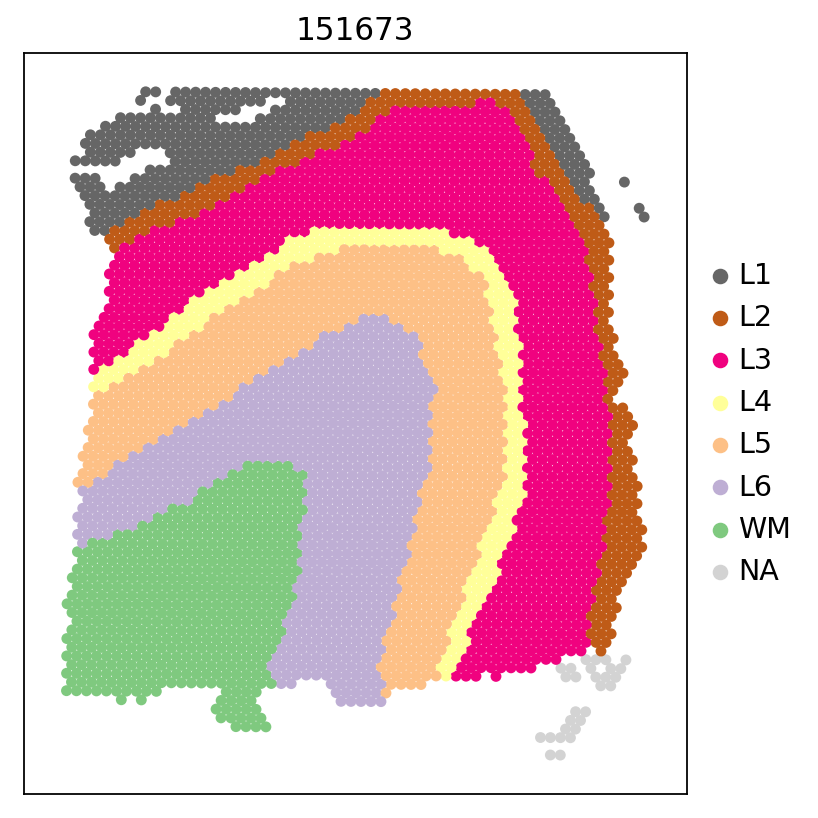

In [45]:
# plot_cell_layers(adata_spatialLIBD_151673.obs)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout=True)

sc.pl.spatial(
    adata_spatialLIBD_d["151673"],
    img_key=None,
    color="spatialLIBD",
    palette="Accent_r",
    size=1.5,
    title="151673",
    # legend_loc = 4,
    spot_size=100,
    show=False,
    ax=ax,
)

ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")

fig.show()


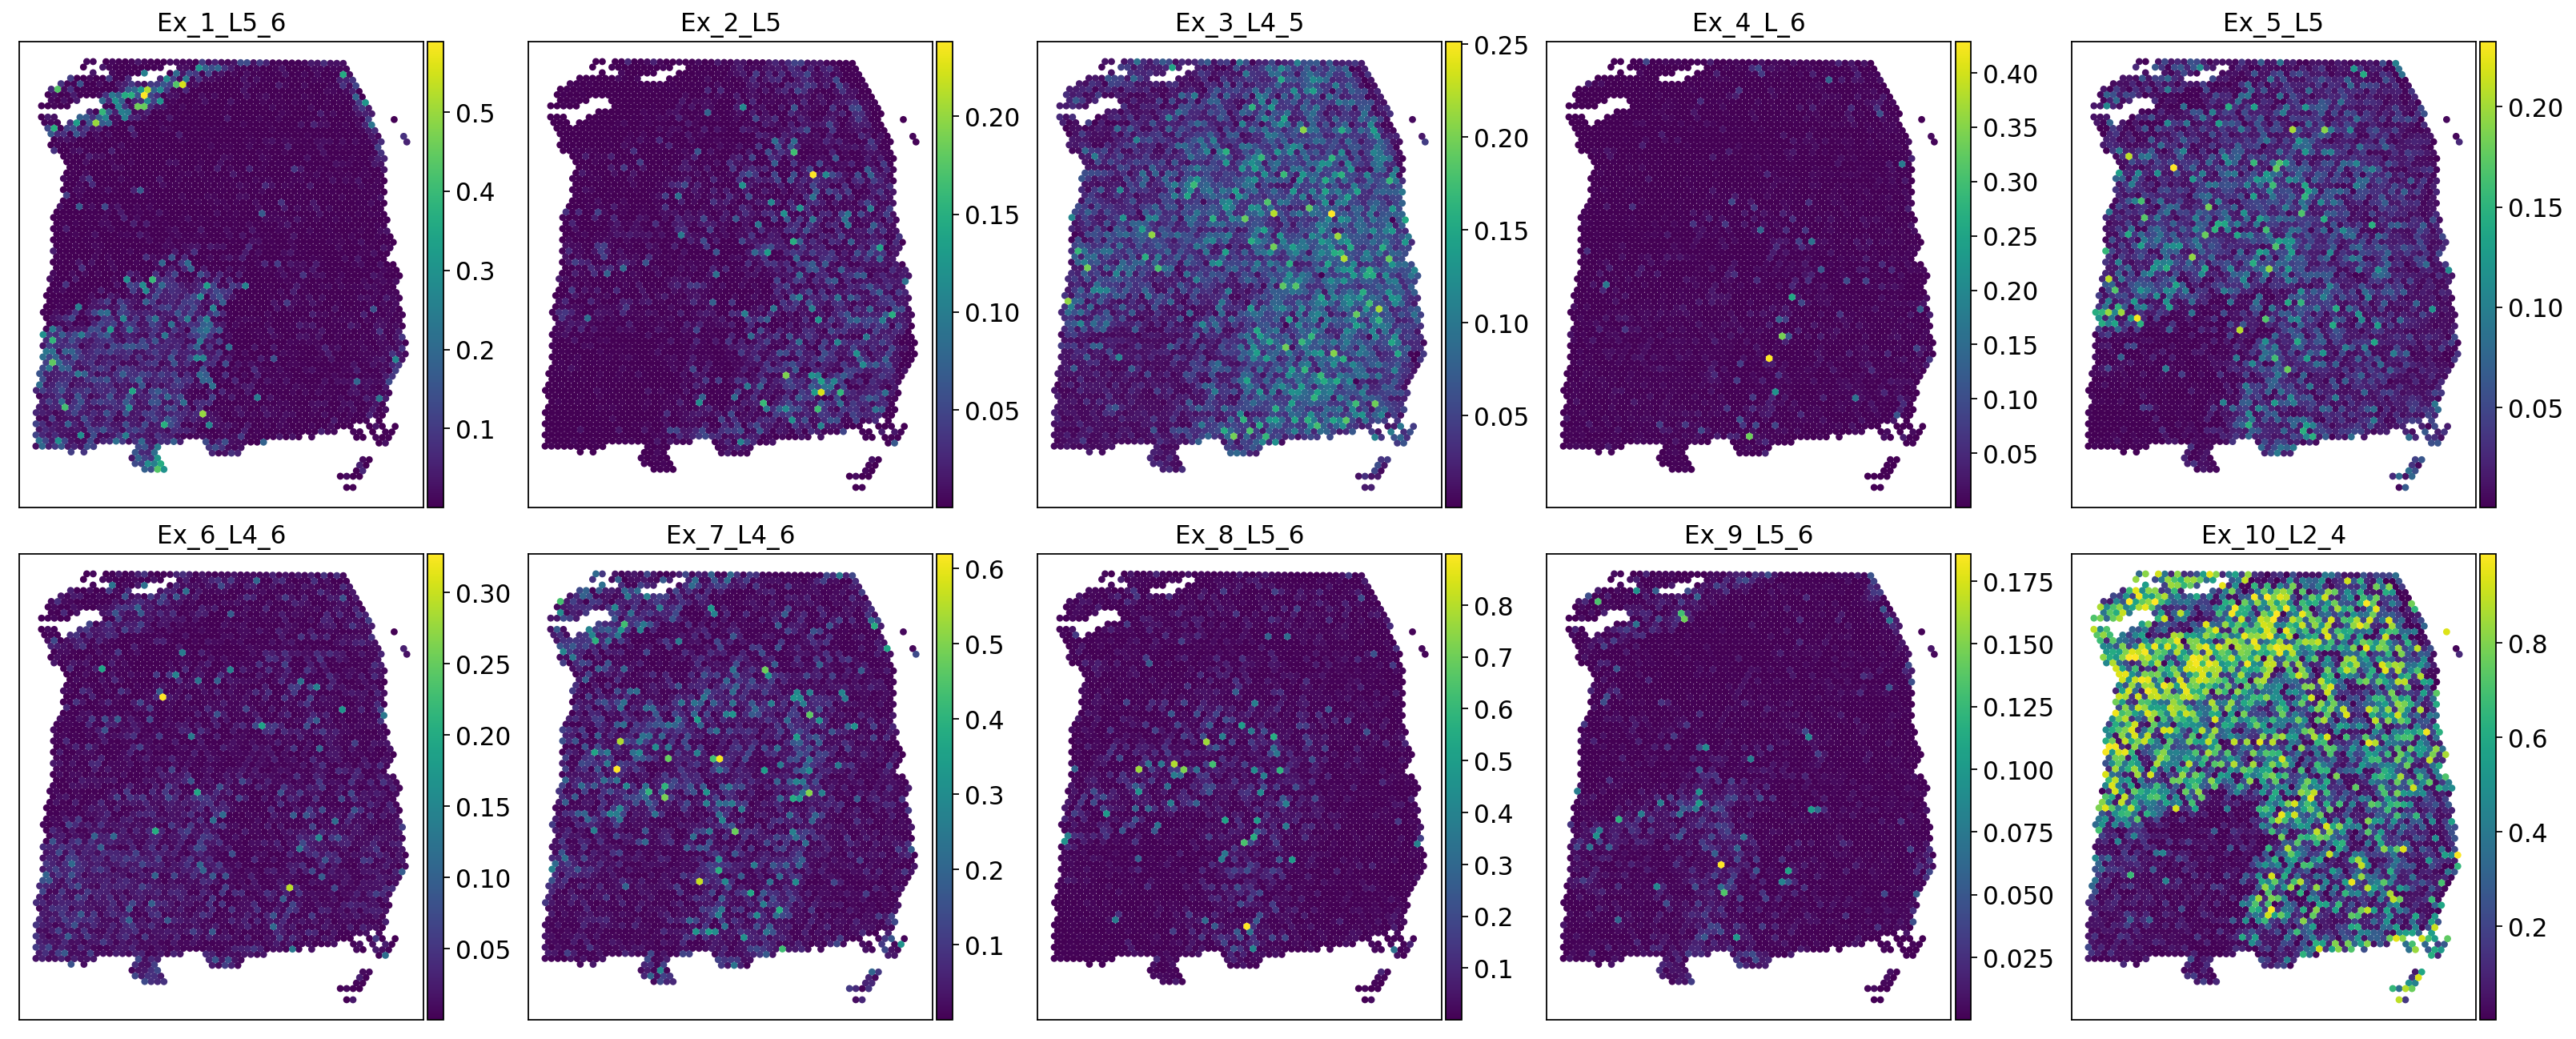

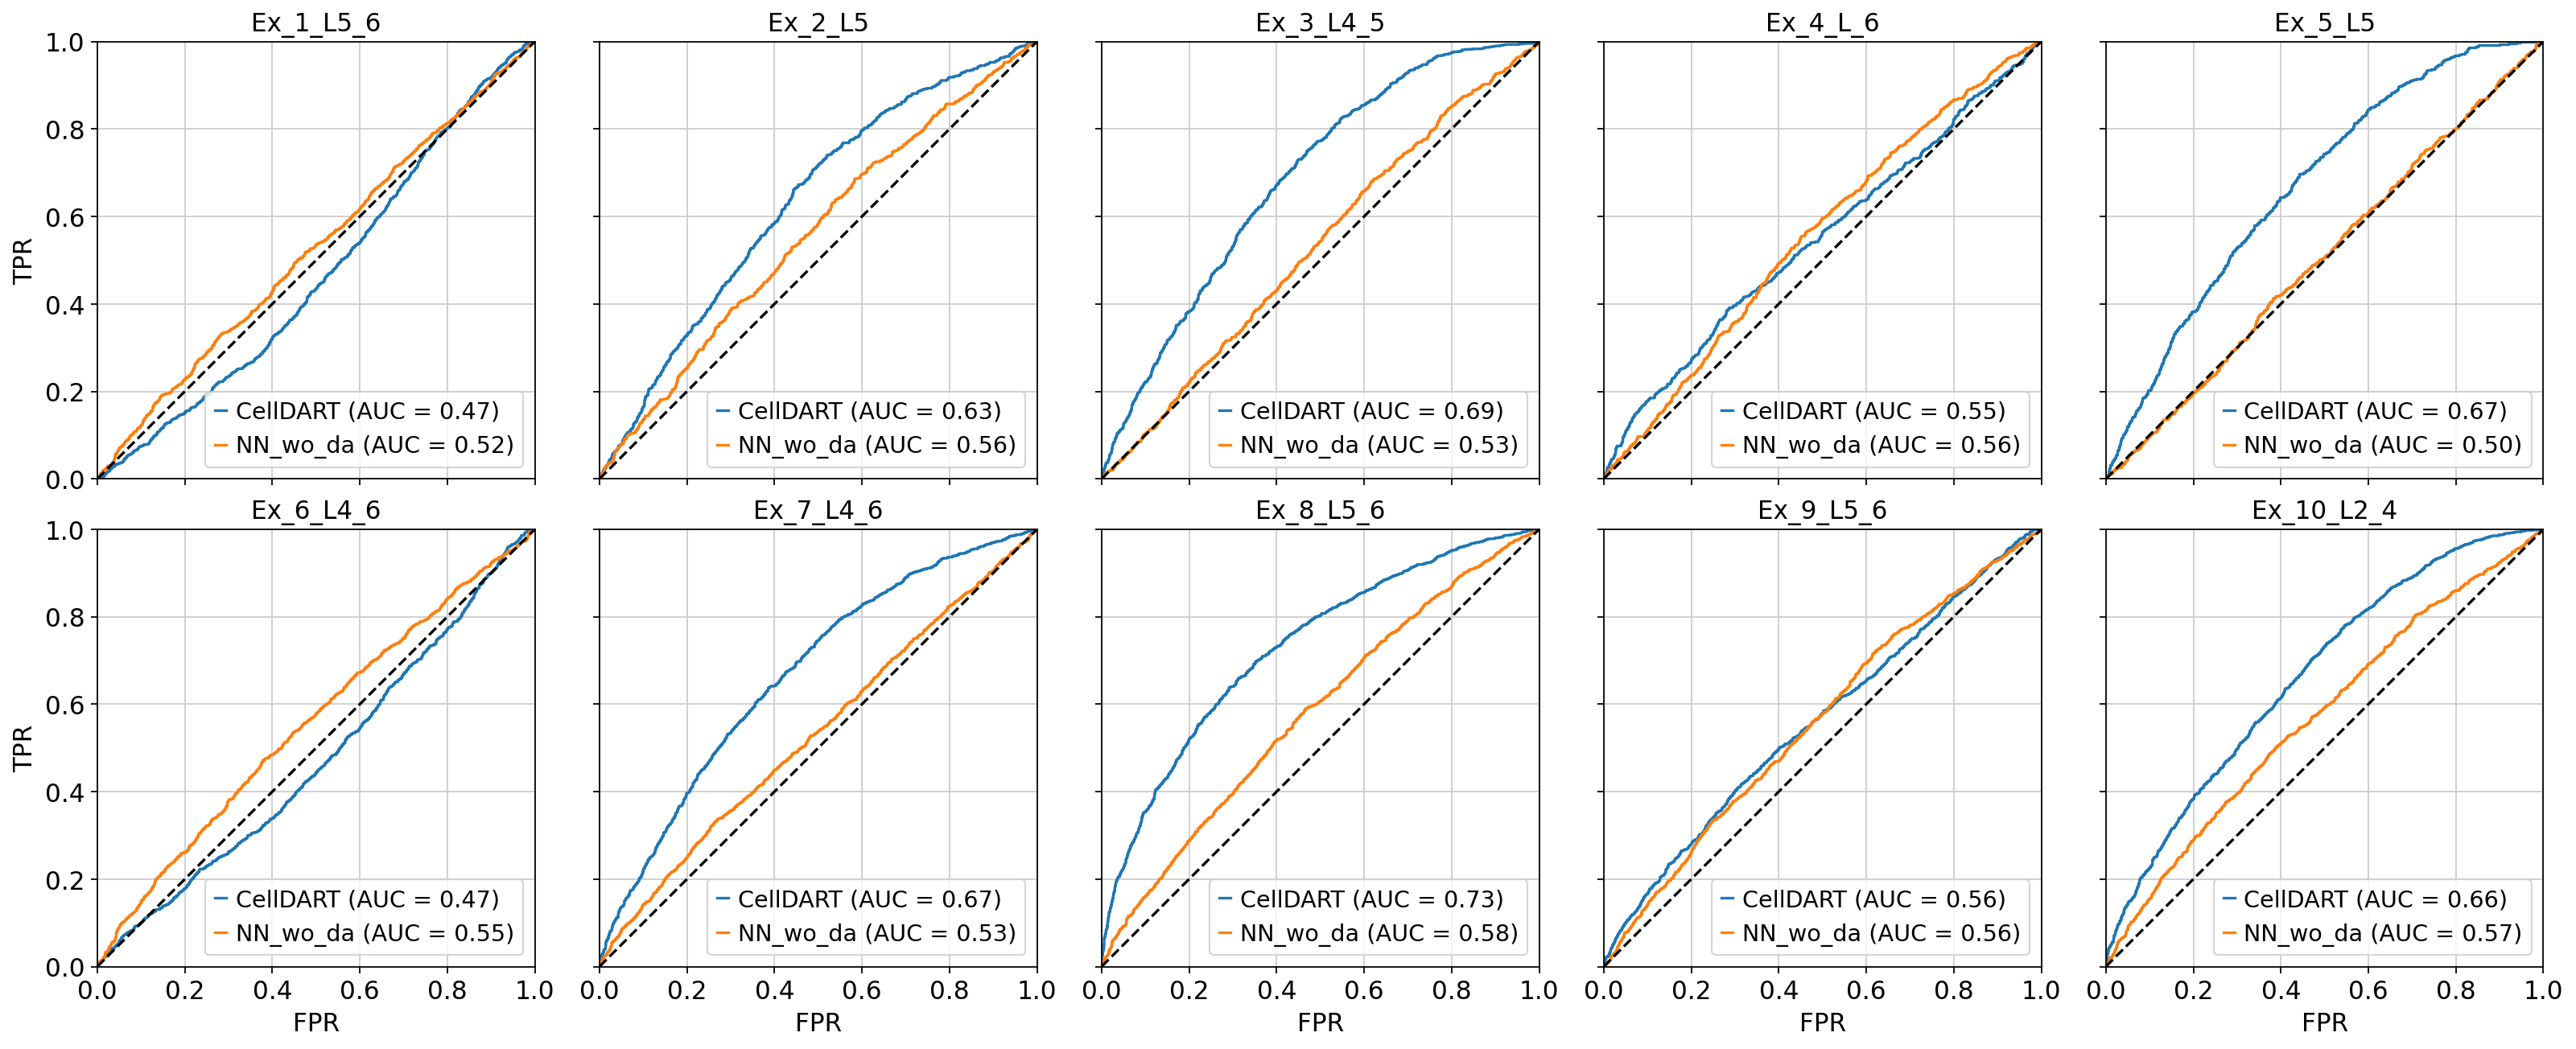

In [46]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

for i, num in enumerate(numlist):
    plot_cellfraction(
        num, adata_spatialLIBD_d["151673"], pred_sp_d["151673"], ax.flat[i]
    )
    ax.flat[i].axis("equal")
    ax.flat[i].set_xlabel("")
    ax.flat[i].set_ylabel("")

fig.show()
# plt.close()

fig, ax = plt.subplots(
    2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
)

for i, num in enumerate(numlist):
    plot_roc(
        num, adata_spatialLIBD_d["151673"], pred_sp_d["151673"], "CellDART", ax.flat[i]
    )
    plot_roc(
        num,
        adata_spatialLIBD_d["151673"],
        pred_sp_noda_d["151673"],
        "NN_wo_da",
        ax.flat[i],
    )
    ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
    ax.flat[i].set_aspect("equal")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    ax.flat[i].set_title(f"{sc_sub_dict[num]}")

    if i >= len(numlist) - 5:
        ax.flat[i].set_xlabel("FPR")
    else:
        ax.flat[i].set_xlabel("")
    if i % 5 == 0:
        ax.flat[i].set_ylabel("TPR")
    else:
        ax.flat[i].set_ylabel("")

fig.show()
# plt.close()


/projects/wma/.conda2/envs/agreda2/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/projects/wma/.conda2/envs/agreda2/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/projects/wma/.conda2/envs/agreda2/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

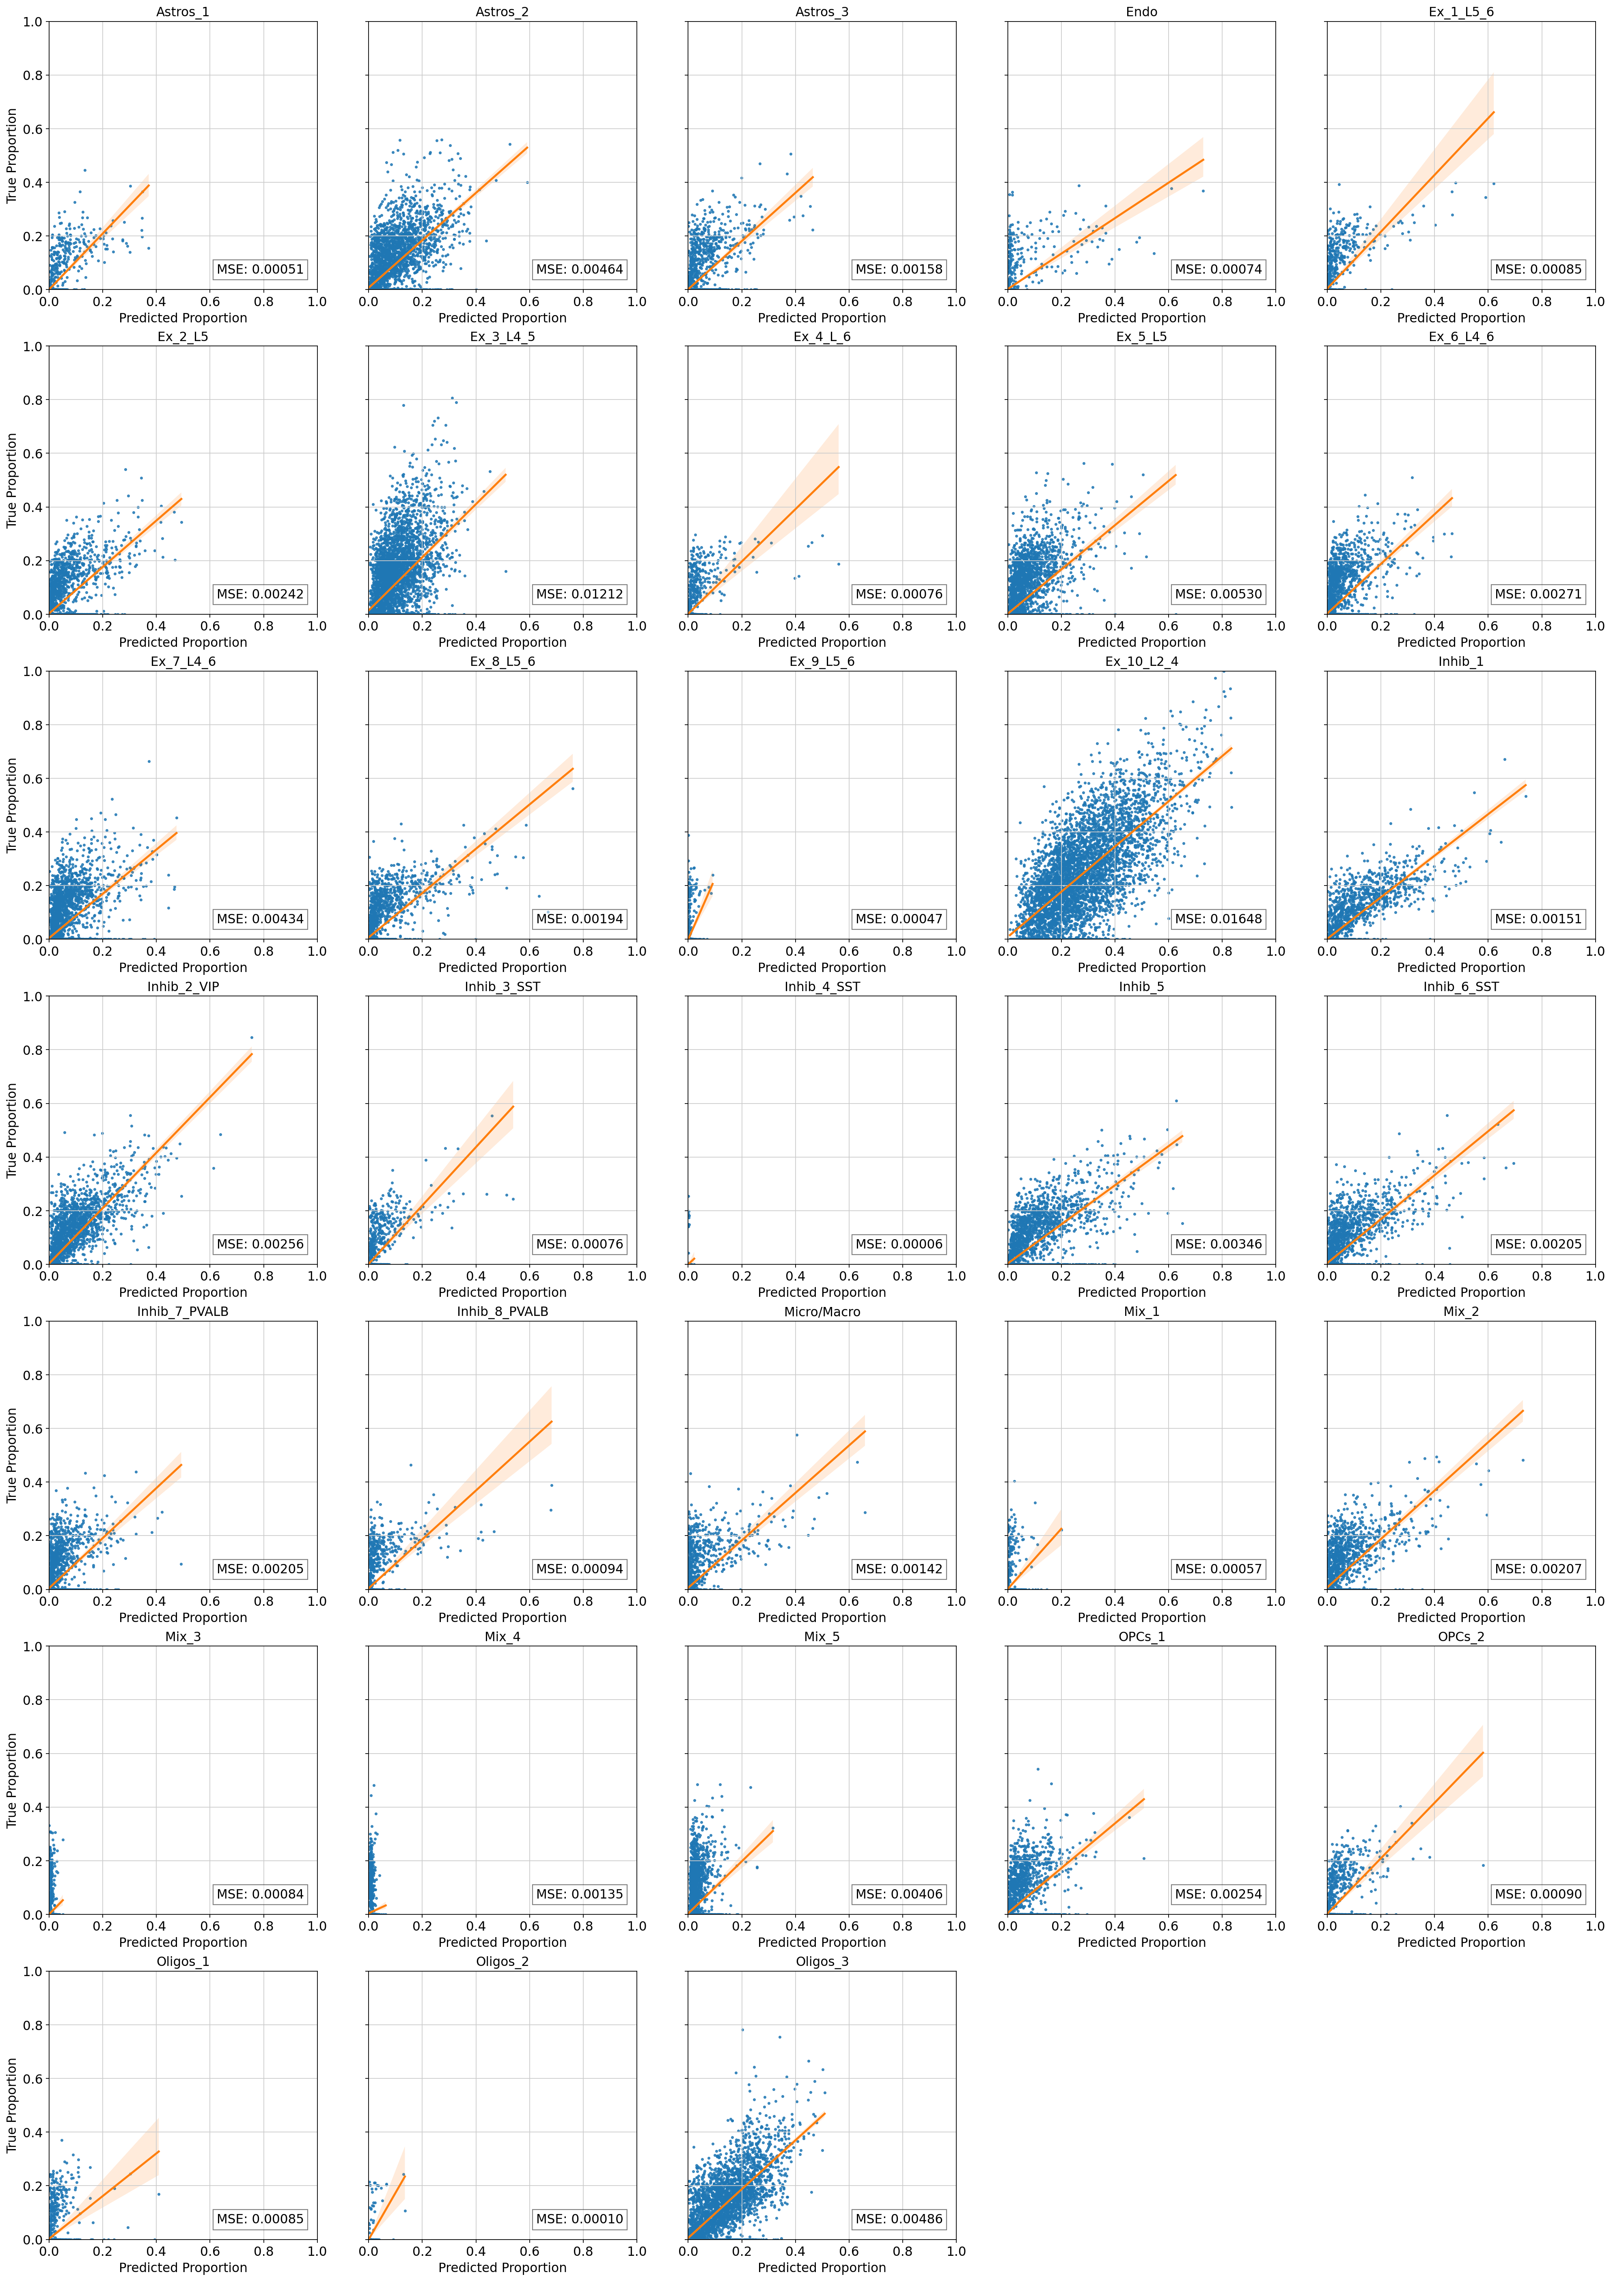

In [47]:
if TRAIN_USING_ALL_ST_SAMPLES:
    best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
else:
    best_checkpoint = torch.load(
        os.path.join(advtrain_folder, "151673", f"final_model.pth")
    )

model = best_checkpoint["model"]
model.to(device)

model.eval()
model.set_encoder("source")

pred_mix = (
    F.softmax(model(torch.Tensor(sc_mix_test_s).to(device)), dim=1)
    .detach()
    .cpu()
    .numpy()
)

cell_type_nums = sc_sub_dict.keys()
nrows = ceil(len(cell_type_nums) / 5)

line_kws = {"color": "tab:orange"}
scatter_kws = {"s": 5}

props = dict(facecolor="w", alpha=0.5)

fig, ax = plt.subplots(
    nrows,
    5,
    figsize=(25, 5 * nrows),
    constrained_layout=True,
    sharex=False,
    sharey=True,
)
for i, visnum in enumerate(cell_type_nums):
    sns.regplot(
        pred_mix[:, visnum],
        lab_mix_test[:, visnum],
        line_kws=line_kws,
        scatter_kws=scatter_kws,
        ax=ax.flat[i],
    ).set_title(sc_sub_dict[visnum])
    ax.flat[i].set_aspect("equal")

    # if i >= len(cell_type_nums) - 5:
    ax.flat[i].set_xlabel("Predicted Proportion")
    # else:
    #     ax.flat[i].set_xlabel('')
    if i % 5 == 0:
        ax.flat[i].set_ylabel("True Proportion")
    else:
        ax.flat[i].set_ylabel("")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    textstr = (
        f"MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}"
    )

    # place a text box in upper left in axes coords
    ax.flat[i].text(
        0.95,
        0.05,
        textstr,
        transform=ax.flat[i].transAxes,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=props,
    )

for i in range(len(cell_type_nums), nrows * 5):
    ax.flat[i].axis("off")

plt.show()
